In [86]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ComplexHeatmap))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
fold_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"
file_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData"
fold <- "OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/"
filt_path_file <- "pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData"
outFold <- sprintf('%sCAD_clustering/', fold_notebook)

tscore_CAD <- read.table(sprintf('%stscore_pval_CAD_HARD_covCorr.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathR_CAD <- read.delim(sprintf('%spath_Reactome_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathGO_CAD <- read.delim(sprintf('%spath_GO_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathWiki_CAD <- read.delim(sprintf('%spath_WikiPath2019Human_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)

tscore_CAD <- tscore_CAD %>% 
    dplyr::mutate(feat_tissue = paste0(ensembl_gene_id, "_", tissue))

tscore_sign <- tscore_CAD %>% 
    dplyr::filter(CAD_HARD_BHcorr < 0.05)

colnames_path <- intersect(colnames(pathWiki_CAD), 
                           intersect(colnames(pathR_CAD), colnames(pathGO_CAD)))

pathR_CAD <- pathR_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "Reactome")

pathGO_CAD <- pathGO_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "GO")

pathWiki_CAD <- pathWiki_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "WikiPathways")

path_CAD <- bind_rows(pathR_CAD, pathGO_CAD, pathWiki_CAD) %>%
    dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))

path_sign <- path_CAD %>%
    dplyr::filter(CAD_HARD_BHcorr < 0.05)

cl <- get(load(file_cl))
n_gr <- length(unique(cl$cl_best$gr))
tscore_gr <- list()
pathR_gr <- list()
pathGO_gr <- list()
pathWiki_gr <- list()
path_gr <- list()

tscore_gr_CADsign <- list()
path_gr_CADsign <- list()

for(i in 1:n_gr){
    tscore_gr[[i]] <- read.table(sprintf('%scluster_specific_PALAS/tscore_pval_ClusterCasesVSControls_gr%i.txt', fold_cl, i), 
                                 header=T, sep = "\t", stringsAsFactors = F) 
    tscore_gr[[i]] <- tscore_gr[[i]] %>% 
        dplyr::mutate(feat_tissue = paste0(ensembl_gene_id, "_", tissue))

    tscore_gr_CADsign[[i]] <- tscore_gr[[i]][match(tscore_sign$feat_tissue, tscore_gr[[i]]$feat_tissue),]

    pathR_gr[[i]] <- read.delim(sprintf('%scluster_specific_PALAS/path_Reactome_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)
    pathGO_gr[[i]] <- read.delim(sprintf('%scluster_specific_PALAS/path_GO_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)
    pathWiki_gr[[i]] <- read.delim(sprintf('%scluster_specific_PALAS/path_WikiPath2019Human_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                   header=T, sep = "\t", stringsAsFactors = F)

    colnames_path <- intersect(colnames(pathWiki_gr[[i]]), 
                               intersect(colnames(pathR_gr[[i]]), colnames(pathGO_gr[[i]])))

    pathR_gr[[i]] <- pathR_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathR_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "Reactome")

    pathGO_gr[[i]] <- pathGO_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathGO_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "GO")

    pathWiki_gr[[i]] <- pathWiki_gr[[i]] %>%
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathWiki_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "WikiPathways")
    
    path_gr[[i]] <- bind_rows(
        pathR_gr[[i]], pathGO_gr[[i]], pathWiki_gr[[i]]) %>%
        dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))
    
    path_gr_CADsign[[i]] <- path_gr[[i]][match(path_sign$full_id, path_gr[[i]]$full_id),]
    
}

dim(path_CAD)
dim(path_sign)

[1] 36949    22

[1] 567  22

- total number of pathways: 36949
- number of pathways sign in CAD: 567

In [66]:
# load WMW results inside cases
tot_path_res <- get(load(sprintf("%spathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData", fold_cl)))
gr_cases_WMW <- bind_rows(tot_path_res$test_feat) %>%
    mutate(feat_tissue = paste(feat, tissue, sep = "_"))

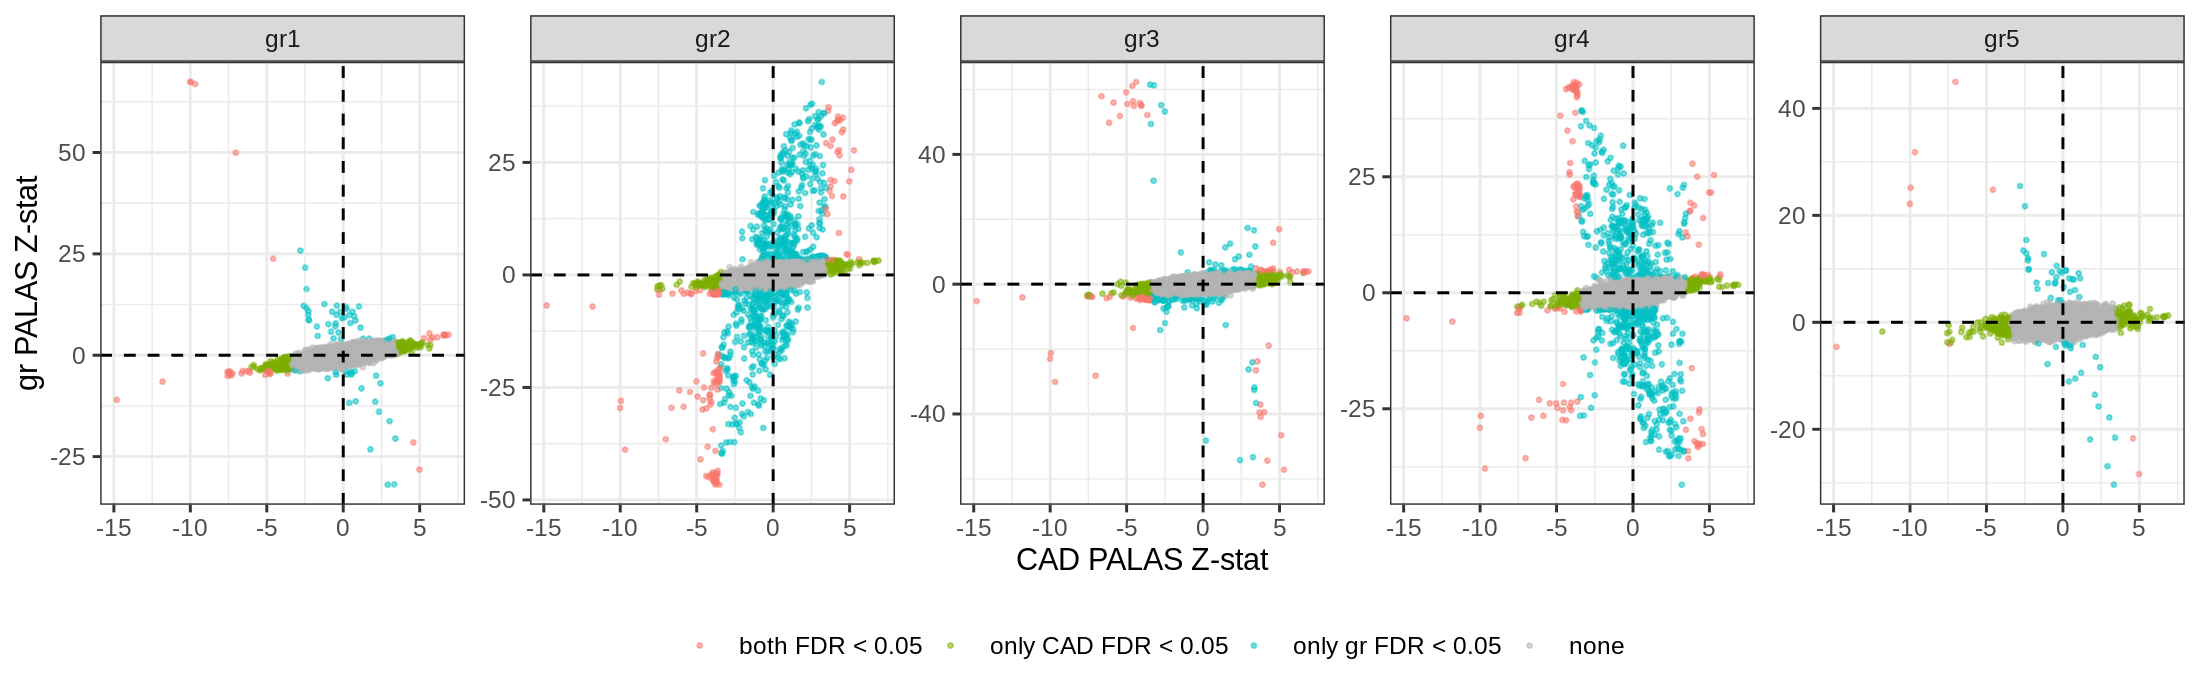

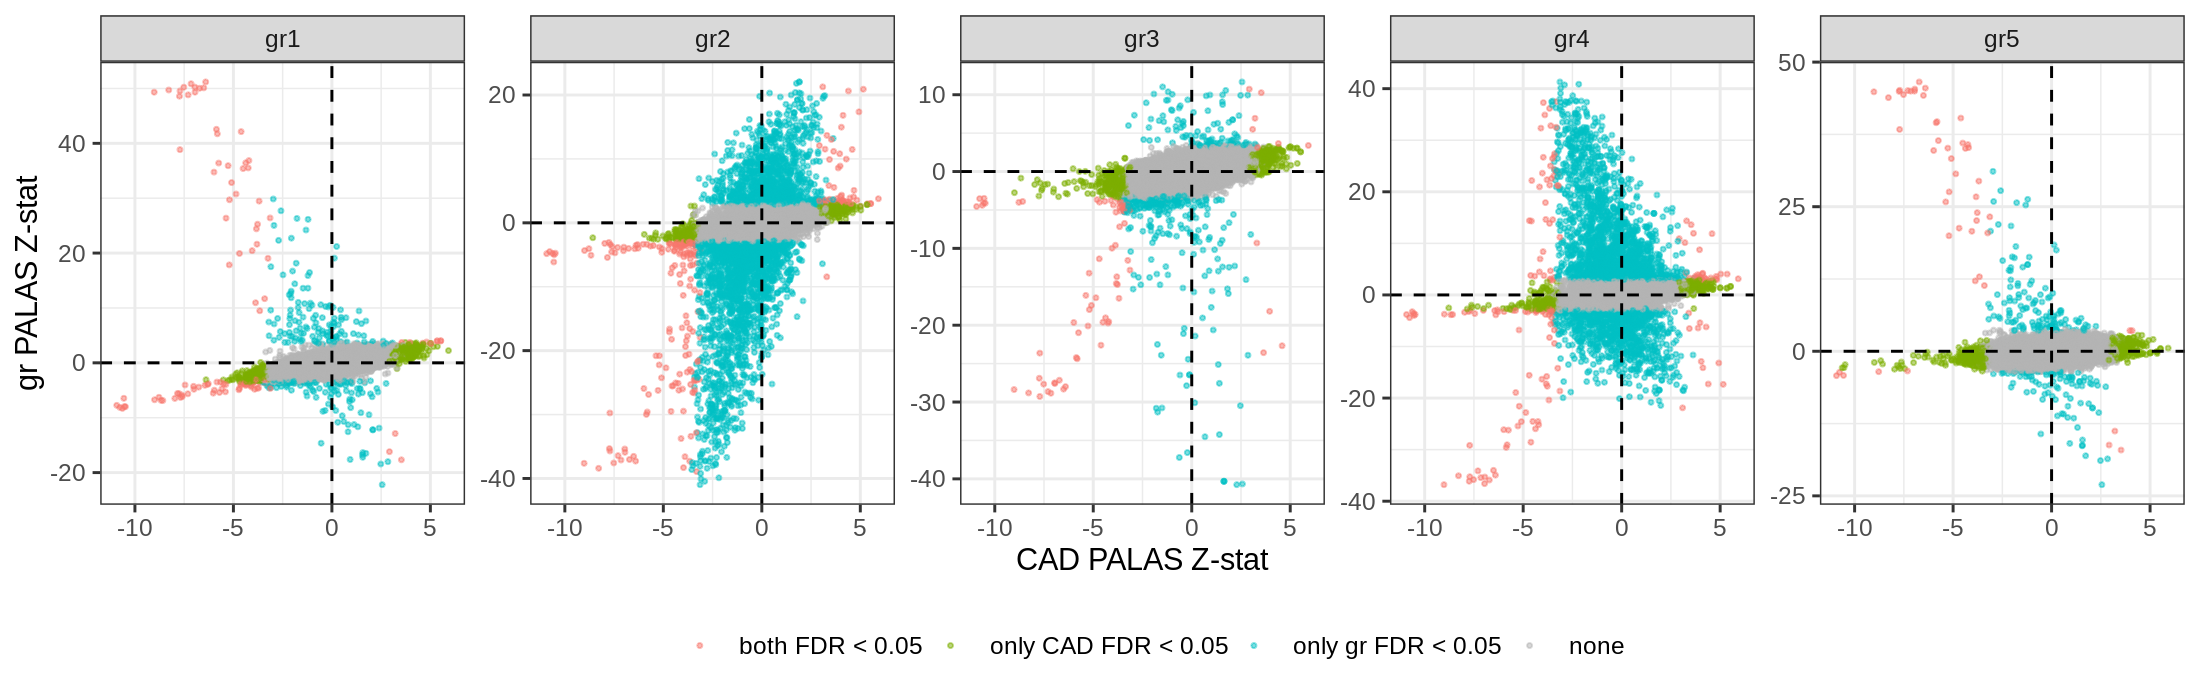

In [161]:
options(repr.plot.width = 11, repr.plot.height = 3.5, repr.plot.res = 200)

scatter_plot_zstat <- function(CAD_res, gr_res, id_zstat, id_pval_corr, pval_corr_thr = 0.05, type_data, outFold){

    df <- list()
for(i in 1:length(path_gr)){
    gr_id  <- i
    df[[i]] <- data.frame(
        gr = paste0("gr", i), 
        CAD_zstat = CAD_res[, id_zstat], 
        gr_zstat = gr_res[[gr_id]][, id_zstat], 
        res_sign = "none") %>%
    mutate(res_sign = case_when(
        CAD_res[, id_pval_corr] <= pval_corr_thr & gr_res[[gr_id]][, id_pval_corr] <= pval_corr_thr ~ "both FDR < 0.05",
        CAD_res[, id_pval_corr] <= pval_corr_thr & gr_res[[gr_id]][, id_pval_corr] > pval_corr_thr  ~ "only CAD FDR < 0.05",
        CAD_res[, id_pval_corr] > pval_corr_thr & gr_res[[gr_id]][, id_pval_corr] <= pval_corr_thr ~ "only gr FDR < 0.05",
        TRUE ~ "none"
    )) %>%
    mutate(res_sign = factor(res_sign, levels = c("both FDR < 0.05", "only CAD FDR < 0.05", "only gr FDR < 0.05", "none")))
}
df <- bind_rows(df)

hex <- hue_pal()(4)

pl <- ggplot(df, aes(x = CAD_zstat, y = gr_zstat, color = res_sign)) +
    geom_point(size = 0.5, alpha = 0.5) +
    facet_wrap(~gr, nrow = 1, scales = "free_y") +
    scale_color_manual(values = c(hex[-length(hex)], "grey70")) +
    geom_hline( yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline( xintercept = 0, linetype = "dashed", color = "black") +
    theme_bw() +
    theme(legend.position = "bottom", legend.title = element_blank()) +
    xlab("CAD PALAS Z-stat") + 
    ylab(sprintf("gr PALAS Z-stat"))

    ggsave(sprintf("%sscatterPlot_PALASzstat_CAD_and_group_%s.png", outFold, type_data), pl, width = 11, height = 3.5, dpi = 200)
    return(pl)
}

scatter_plot_zstat(tscore_CAD, tscore_gr, 7, 10, pval_corr_thr = 0.05, type_data = "tscore", outFold = outFold)
scatter_plot_zstat(path_CAD, path_gr, 12, 15, pval_corr_thr = 0.05, type_data = "path", outFold = outFold)


Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”


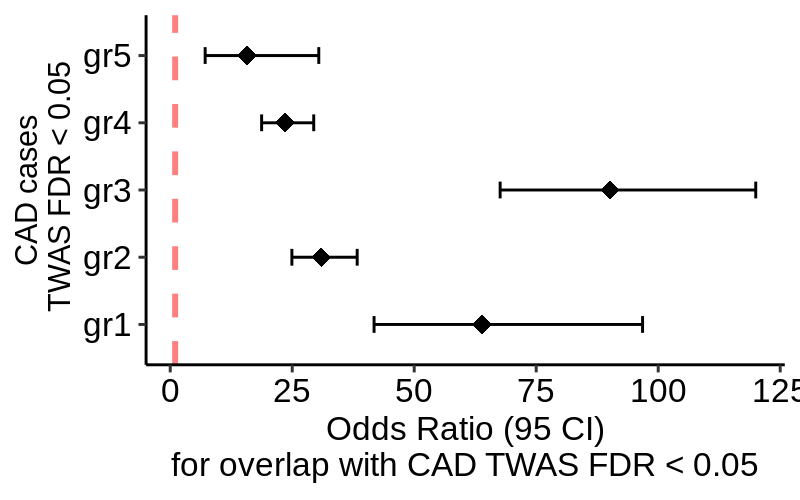

estimate,lower,upper,gr,pvalue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
38.410291,30.133946,48.810710,gr1,2.827135e-121
7.355922,6.190476,8.724613,gr2,5.406736e-93
14.286874,11.014715,18.320051,gr3,1.101993e-57
4.647381,3.854306,5.580189,gr4,2.201493e-47
15.798143,11.330756,21.616723,gr5,7.537188e-38


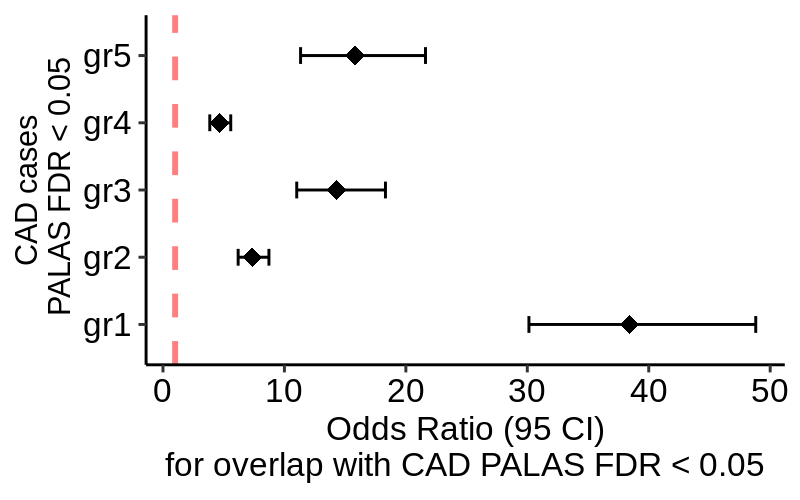

In [83]:
library(epitools)
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)

compute_enrichment <- function(res_CAD, res_gr, pval_corr_thr, id_pval_corr, type_data, outFold){
    
    df <- list()
    for(i in 1:length(res_gr)){
        data <- table(res_CAD[, id_pval_corr] <= pval_corr_thr, res_gr[[i]][,id_pval_corr] <= pval_corr_thr)
        dimnames(data) <- list('Group' = c("FDR > 0.05", "FDR < 0.05"), 'CAD' = c("FDR > 0.05", "FDR < 0.05"))
        df[[i]] <- as.data.frame(t(oddsratio(data)$measure["FDR < 0.05",])) %>% mutate(gr = i, pvalue = oddsratio(data)$p.value["FDR < 0.05", 2])
    }
    df <- bind_rows(df) %>%
        mutate(gr = paste0("gr", gr))
    
    pl <- ggplot(df, aes(y = gr, x = estimate)) +
    geom_point(shape = 18, size = 3) +  
    geom_errorbarh(aes(xmin = lower, xmax = upper), height = 0.25) +
    geom_vline(xintercept = 1, color = "red", linetype = "dashed", cex = 1, alpha = 0.5) +
    # scale_y_continuous(name = "", breaks=1:4, labels = dat$, trans = "reverse") +
    xlab(sprintf("Odds Ratio (95 CI)\nfor overlap with CAD %s FDR < 0.05", type_data)) + 
    ylab(sprintf("CAD cases\n %s FDR < 0.05", type_data)) + 
    theme_bw() +
    theme(panel.border = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text.y = element_text(size = 12, colour = "black"),
        axis.text.x.bottom = element_text(size = 12, colour = "black"),
        axis.title.x = element_text(size = 12, colour = "black"))

    print(pl)
    ggsave(sprintf("%s%s_enrichment_CAD_and_group_FDR005.pdf", outFold, type_data), pl, width = 4, height = 2.5, dpi = 300)
    #df <- data.frame(OR = rep(NA, length(res_gr)), pvalue_fisher = rep(NA, length(res_gr)))
    #df$OR <- unname(sapply(res_gr, function(x) 
    #fisher.test(table(x[,id_pval_corr] <= pval_corr_thr, res_CAD[, id_pval_corr] <= pval_corr_thr))$estimate))
    #df$pvalue_fisher <- unname(sapply(res_gr, function(x) 
    #fisher.test(table(x[,id_pval_corr] <= pval_corr_thr, res_CAD[, id_pval_corr] <= pval_corr_thr))$p.value))
    return(df)
}
df_tscore <- compute_enrichment(tscore_CAD, tscore_gr, pval_corr_thr = 0.05, id_pval_corr = 10, type_data = "TWAS", outFold = outFold)
df_path <- compute_enrichment(path_CAD, path_gr, pval_corr_thr = 0.05, id_pval_corr = 15, type_data = "PALAS", outFold = outFold)
df_path

In [88]:
# get unique paths across tissues (best z-stat in CAD), remove those that are discordant across tissues based on z-stat sign
id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15 

path_sign_notuniq <- path_sign %>% 
    dplyr::group_by(path, type) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues > 1) %>%
    dplyr::mutate(path_type = paste0(path, "_", type)) %>%
    dplyr::ungroup()

path_name <- path_sign_notuniq %>% 
    dplyr::pull(path_type) %>%
    unique() 
length(path_name)

keep_path <- data.frame()

for(i in 1:length(path_name)){
    tmp <- path_sign %>% 
    dplyr::mutate(path_type = paste0(path, "_", type)) %>%
    dplyr::filter(path_type == path_name[i])
    
    if(all(sign(tmp[, id_zstat]) == 1) | all(sign(tmp[, id_zstat]) == -1)){
        tmp <- tmp[which.min(tmp[, id_pval]), ]
        keep_path <- rbind(keep_path, tmp)
    }  
}
dim(keep_path)

path_sign_conc <- path_sign %>% 
    dplyr::group_by(path, type) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues == 1) %>%
    dplyr::select(-n_tissues) %>%
    dplyr::ungroup()
dim(path_sign_conc)

path_sign_conc <- bind_rows(
    path_sign_conc, 
    keep_path %>% dplyr::select(-path_type))

dim(path_sign_conc)
dim(path_sign)


[1] 65

[1] 62 23

[1] 399  22

[1] 461  22

[1] 567  22

- 567 significant pathways across GO, Reactome and wiki
- Of those, 399 are only in a tissue.
- 168 are in more than one tissue, 65 are unique
- We filter 65 pathways keeping only those more significant if the Z-stat sign is concordant, if not we discard it. Resulting number is 62 pathways
- The total list includes 461 pathways

In [89]:
# get unique genes across tissues (best z-stat in CAD), remove those that are discordant across tissues based on z-stat sign
id_zstat <- 7
id_pval <- 8
id_pval_corr <- 10 

tscore_sign_notuniq <- tscore_sign %>% 
    dplyr::group_by(ensembl_gene_id) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues > 1) %>%
    dplyr::ungroup()

gene_name <- tscore_sign_notuniq %>% 
    dplyr::pull(ensembl_gene_id) %>%
    unique() 
length(gene_name)

keep_gene <- data.frame()

for(i in 1:length(gene_name)){
    tmp <- tscore_sign %>% 
    dplyr::filter(ensembl_gene_id == gene_name[i])
    
    if(all(sign(tmp[, id_zstat]) == 1) | all(sign(tmp[, id_zstat]) == -1)){
        tmp <- tmp[which.min(tmp[, id_pval]), ]
        keep_gene <- rbind(keep_gene, tmp)
    }  
}
dim(keep_gene)

tscore_sign_conc <- tscore_sign %>% 
    dplyr::group_by(ensembl_gene_id) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues == 1) %>%
    dplyr::select(-n_tissues) %>%
    dplyr::ungroup()
dim(tscore_sign_conc)

tscore_sign_conc <- bind_rows(
    tscore_sign_conc, 
    keep_gene)

dim(tscore_sign_conc)
dim(tscore_sign)

[1] 62

[1] 62 13

[1] 118  13

[1] 180  13

[1] 383  13

- 383 significant genes
- Of those, 118 are only in a tissue.
- 265 are in more than one tissue, 62 are unique
- All of this 62 have the same Z-stat sign in all tissues
- The total list includes 180 tissues

In [90]:
get_short_name <- function(tissue_name){
    tmp <- sapply(strsplit(tissue_name, split = '_')[[1]], function(x) 
        substr(x = x, start = 1, stop = 1))
    out <- paste0(tmp, collapse = '')
    out <- paste0('(', out,')')
    return(out)
}

path_sign_conc <- path_sign_conc %>% 
    dplyr::mutate(short_tissue = sapply(tissue, function(x) get_short_name(x))) %>%
    dplyr::mutate(plot_id = paste(path, short_tissue))

tscore_sign_conc <- tscore_sign_conc %>% 
    dplyr::mutate(short_tissue = sapply(tissue, function(x) get_short_name(x))) %>%
    dplyr::mutate(plot_id = paste(external_gene_name, short_tissue))

path_gr_CADsign_conc <- list()
for(i in 1:n_gr){
    path_gr_CADsign_conc[[i]] <- path_gr_CADsign[[i]][match(path_sign_conc$full_id, path_gr_CADsign[[i]]$full_id),]
}

tscore_gr_CADsign_conc <- list()
for(i in 1:n_gr){
    tscore_gr_CADsign_conc[[i]] <- tscore_gr_CADsign[[i]][match(tscore_sign_conc$feat_tissue, tscore_gr_CADsign[[i]]$feat_tissue),]
}
                       

In [147]:
# plot heatmap of z-stat for CAD and group
id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15
pval_corr_thr <- 0.05

mat_zstat <- cbind(path_sign_conc[, id_zstat], sapply(path_gr_CADsign_conc, function(x) x[, id_zstat]))
mat_pval <- cbind(path_sign_conc[, id_pval_corr], sapply(path_gr_CADsign_conc, function(x) x[, id_pval_corr]))
rownames(mat_zstat) <- rownames(mat_pval) <- path_sign_conc$plot_id
colnames(mat_zstat) <- colnames(mat_pval) <- c("CAD", paste0("gr", 1:n_gr))

val_min <- min(mat_zstat[,1])
val_max <- max(mat_zstat[,1])
mat_breaks <- seq(val_min, val_max, length.out = 100)
mat_zstat[mat_zstat >= val_max] <- val_max
mat_zstat[mat_zstat <= val_min] <- val_min

count_gr <- c(length(cl$cl_best$gr), table(cl$cl_best$gr))
count_gr
# save 
write.table(mat_zstat, sprintf('%sheatmap_PALASzstat_CAD_and_ClusterCases.txt', outFold), 
            sep = "\t", quote = F, row.names = T, col.names = T)
write.table(mat_pval, sprintf('%sheatmap_PALASpvalue_CAD_and_ClusterCases.txt', outFold), 
            sep = "\t", quote = F, row.names = T, col.names = T)

# path to plot:
list_plot <- c("cyclin-dependent protein serine/threonine kinase inhibitor activity (CS)", 
               "Golgi Associated Vesicle Biogenesis (L)", 
               "glucose import (L)", 
               "Aryl Hydrocarbon Receptor WP2586 (WB)", 
               "GPCRs, Other WP117 (CS)", "triglyceride catabolic process (WB)", 
               "Cellular responses to stress (CS)", 
               "miRs in Muscle Cell Differentiation WP2012 (AC)", 
               "muscle myosin complex (HLV)", "Plasma lipoprotein assembly (AA)", "Xenobiotics (AVO)", "glutathione peroxidase activity (L)", 
               "HDL assembly (AA)", "cellular response to BMP stimulus (AA)", "cellular response to calcium ion (HAA)", 
               "Assembly of collagen fibrils and other multimeric structures (AA)", 
               "lipid transport (L)", "Extracellular vesicles in the crosstalk of cardiac cells WP4300 (AA)",
              "sodium channel inhibitor activity (WB)", "actin filament (HLV)", "Plasma lipoprotein assembly, remodeling, and clearance (L)", 
              "T cell receptor signaling pathway (AA)","Proteasome Degradation WP183 (HAA)", "antigen processing and presentation (L)", 
              "apolipoprotein binding (L)", 
              "response to vitamin D (AG)", 
              "Fatty Acid Beta Oxidation WP143 (WB)", 
              "Downregulation of TGF-beta receptor signaling (AG)", 
              "triglyceride catabolic process (WB)", 
              "Death Receptor Signalling (AA)")


1     2     3     4     5 
19023  6105  4783  2831  4520   784

png 
  2

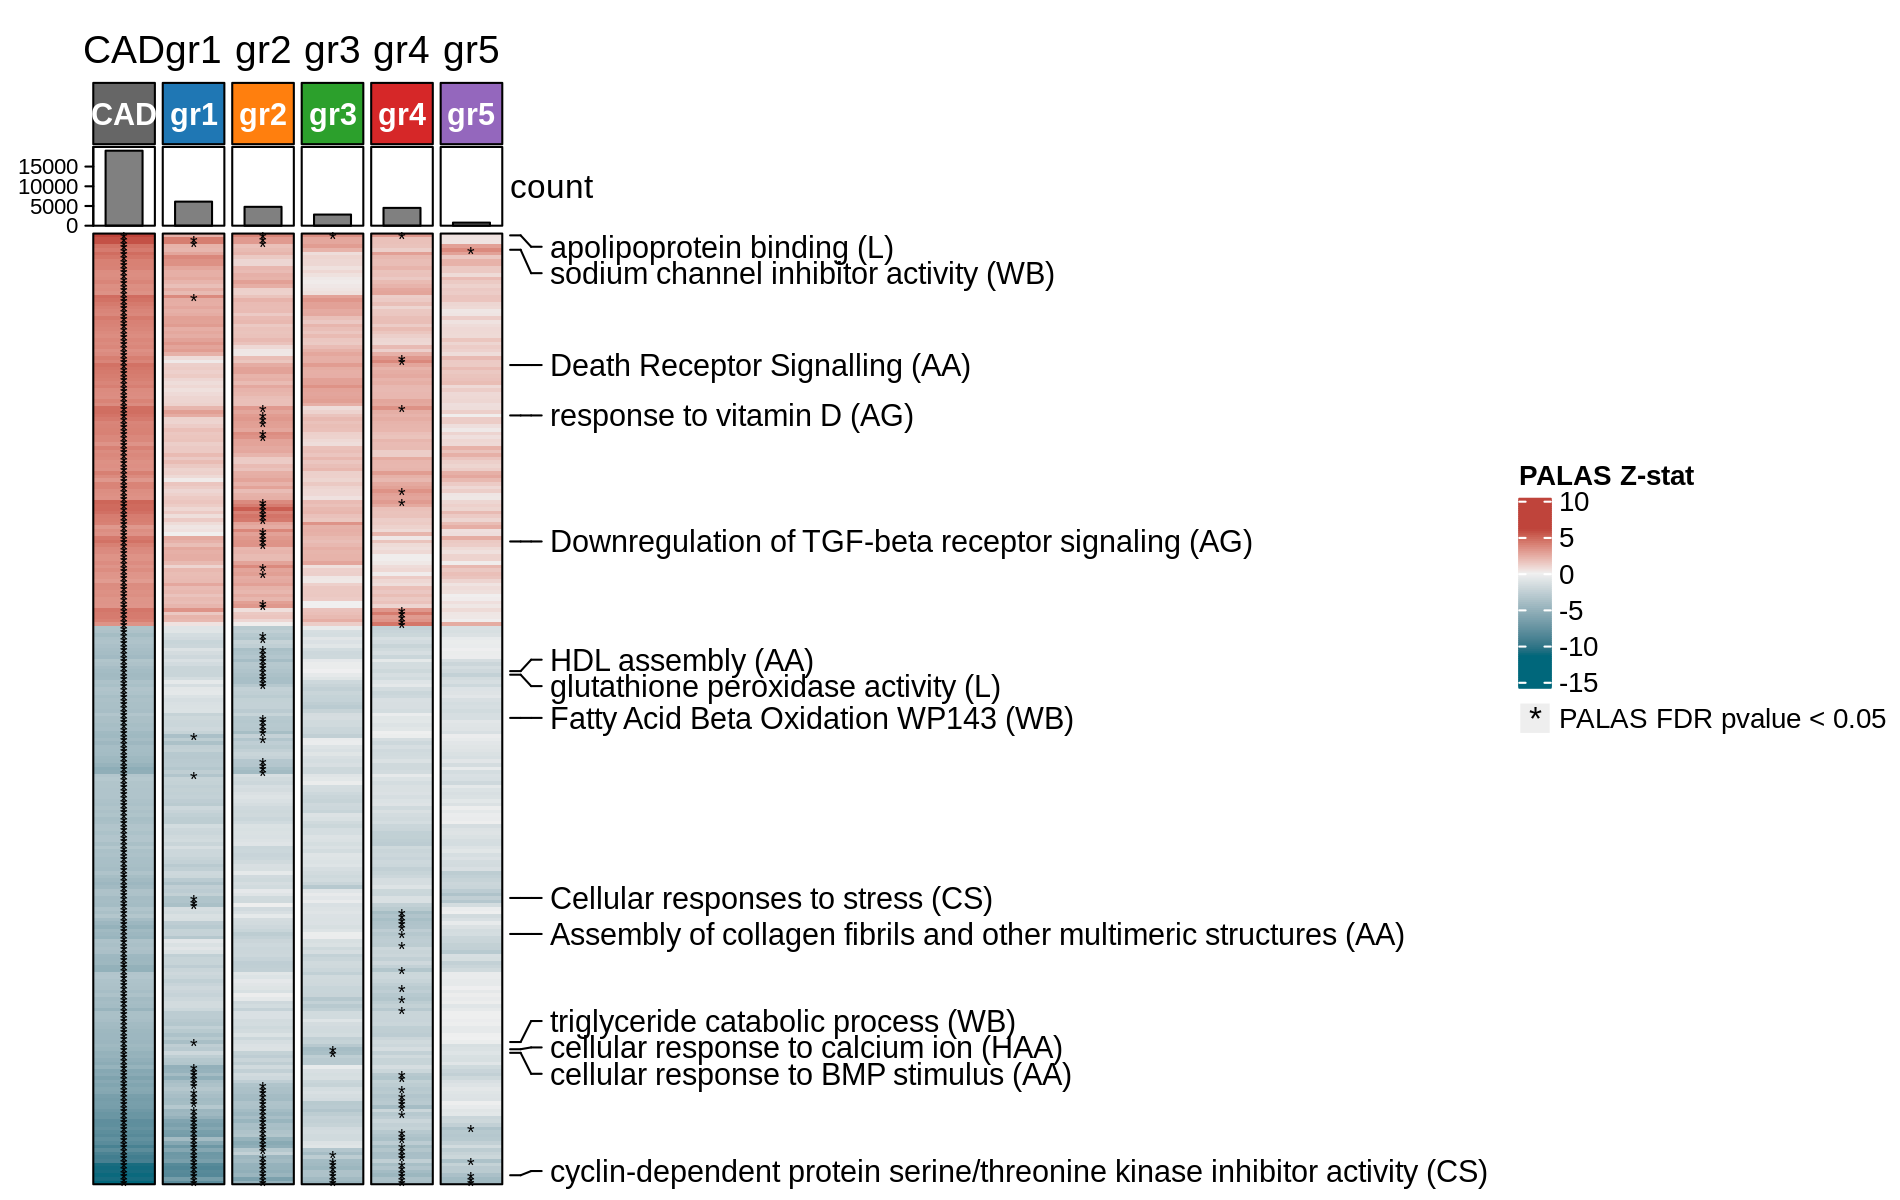

In [141]:
# plot only results concordant in sign
options(repr.plot.width = 9.5, repr.plot.height = 6, repr.plot.res = 200)

id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15
pval_corr_thr <- 0.05

id_plot <- which(apply(mat_zstat,1, function(x) all(sign(x) == 1) | all(sign(x) == -1)))
mat_zstat_c <- mat_zstat[id_plot, ]

mat_pval_c <- as.matrix(mat_pval[rownames(mat_zstat_c),])
feat_pvcorr_pch <- as.matrix(mat_pval_c)
feat_pvcorr_pch[as.matrix(mat_pval_c) <= pval_corr_thr] <- '*'
feat_pvcorr_pch[as.matrix(mat_pval_c) > pval_corr_thr] <- ''

id <- which(rownames(mat_zstat_c) %in% list_plot)

estimate_col_fun = colorRamp2(c(min(mat_zstat_c), 0, max(mat_zstat_c)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
lgd_est <- Legend(title = "PALAS Z-stat", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("PALAS FDR pvalue < %s", as.character(pval_corr_thr)))

mat_colors_gr <- list(cluster = c("grey40", pal_d3(palette = 'category20')(n_gr)))
names(mat_colors_gr$cluster) <- c("CAD", paste0("gr", 1:n_gr))
column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 11,  
                                                                     fontface = "bold")), 
                               count = anno_barplot(count_gr))


row_ha_names <- rowAnnotation(foo = anno_mark(at = id, 
                                              labels = rownames(mat_zstat_c)[id], 
                                              labels_gp = gpar(fontsize = 11))) 

# order
hm_pl <- Heatmap(as.matrix(mat_zstat_c),
                 top_annotation = column_ha, 
                 right_annotation = row_ha_names, 
                 cluster_rows = TRUE, 
                 cluster_columns = FALSE, 
                 show_column_names = FALSE, 
                 show_row_names = FALSE, 
                 show_row_dend=FALSE, 
                 border = TRUE, 
                 show_heatmap_legend = FALSE,
                 column_split = c("CAD", paste0("gr", 1:n_gr)),
                 col = estimate_col_fun, 
                 cell_fun = function(j, i, x, y, w, h, f) {
	             gb = textGrob("*")
	             gb_w = convertWidth(grobWidth(gb), "mm")
	             gb_h = convertHeight(grobHeight(gb), "mm")
	             grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y - gb_h*0.38 + gb_w*0.4, gp = gpar(fontsize = 7))})
                 #cell_fun = function(j, i, x, y, width, height, fill){
                 #          grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 8))})

draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
pdf(sprintf('%sheatmap_PALAS_CAD_and_ClusterCases_concordant.pdf', outFold), width= 9.5, height = 6)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
dev.off()


In [145]:
colSums(mat_pval_c <= pval_corr_thr)
table(rowSums(mat_pval_c[, -1] <= pval_corr_thr) > 0)/nrow(mat_pval_c)
table(rowSums(mat_pval_c[, -1] <= pval_corr_thr) > 0)

CAD gr1 gr2 gr3 gr4 gr5 
264  40  74  11  43   6


    FALSE      TRUE 
0.5871212 0.4128788 


FALSE  TRUE 
  155   109 

- 264 pathways with common sign across groups and CAD
- of those, 109 are significant in at least 1 group (41%)
- and for each group, the n. of associations is gr1 = 40, gr2 = 74, gr3 = 11, gr4 = 43, gr5 = 6

png 
  2

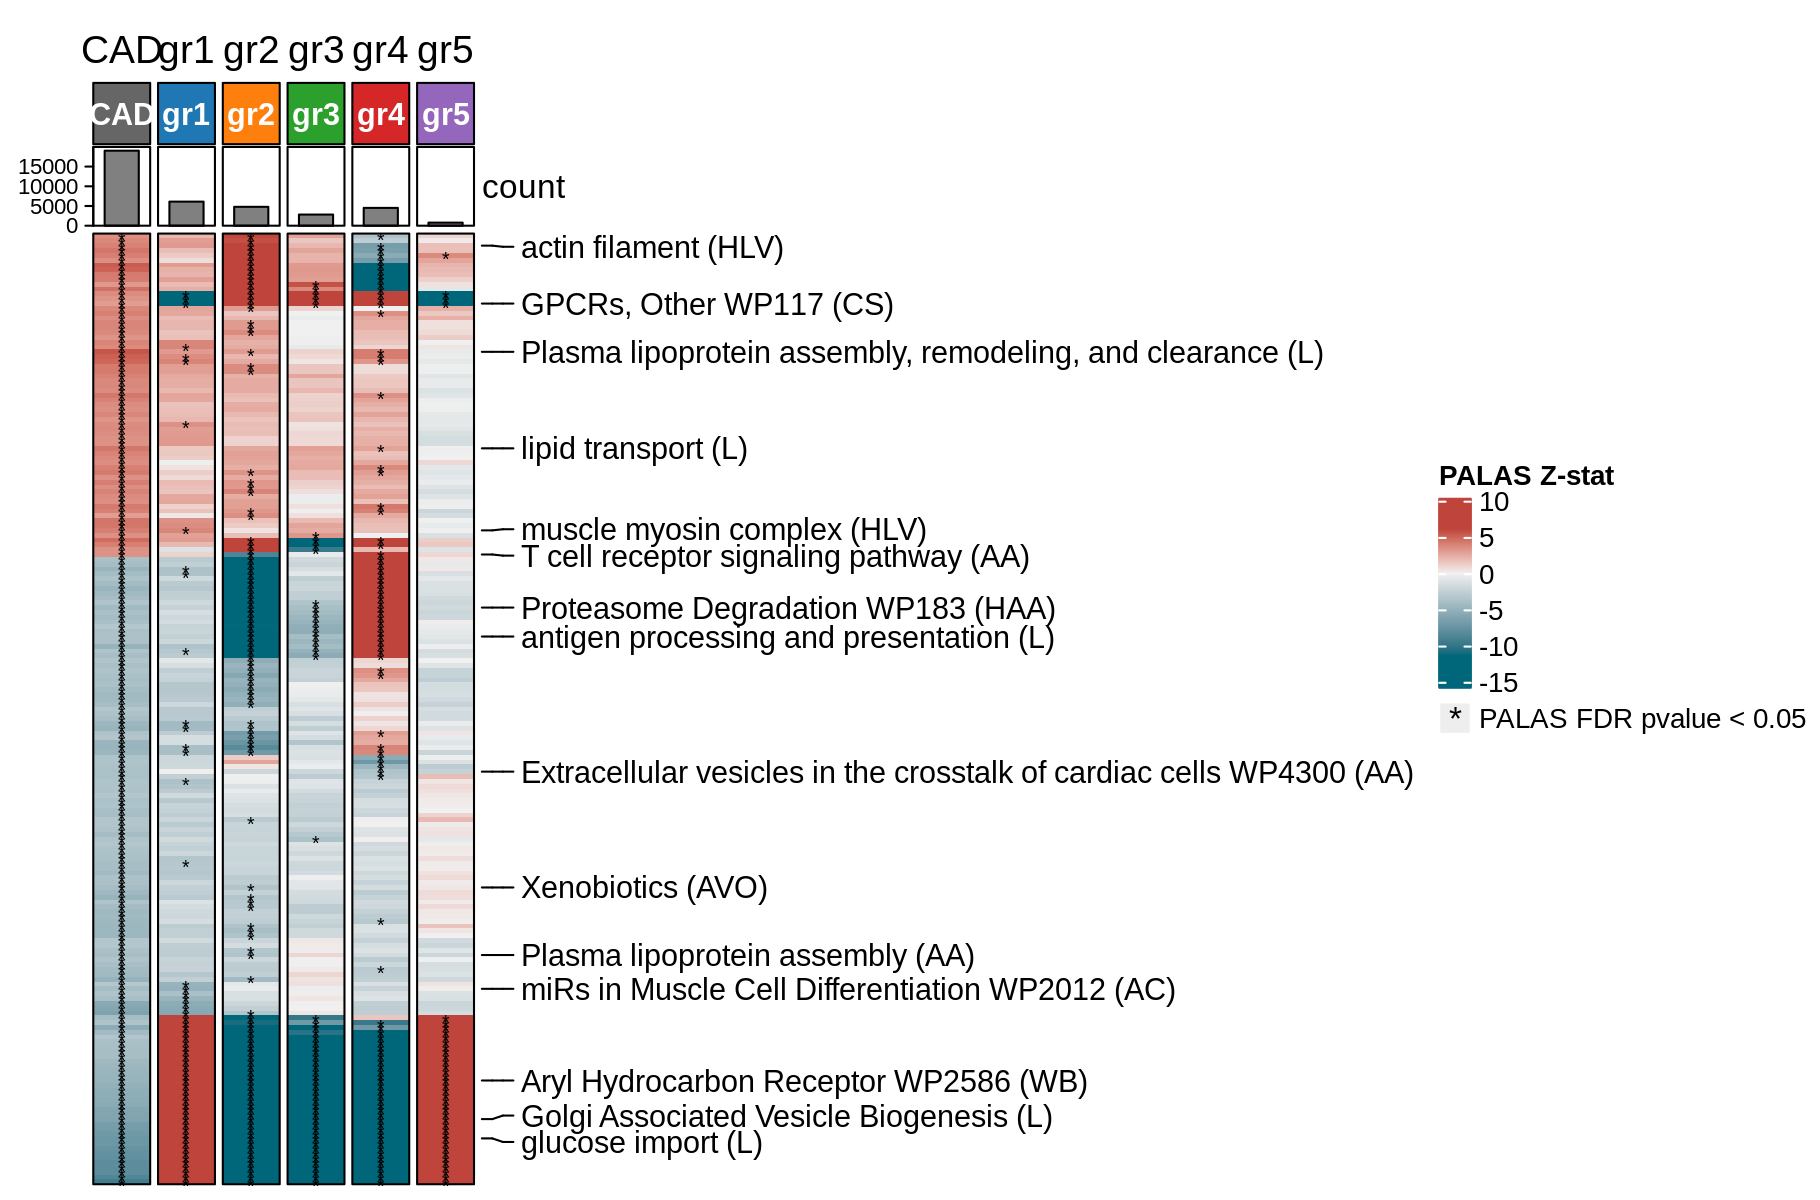

In [154]:
# plot only results concordant in sign
options(repr.plot.width = 9.1, repr.plot.height = 6, repr.plot.res = 200)

id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15
pval_corr_thr <- 0.05

id_plot <- which(!apply(mat_zstat,1, function(x) all(sign(x) == 1) | all(sign(x) == -1)))
mat_zstat_nc <- mat_zstat[id_plot, ]

mat_pval_nc <- as.matrix(mat_pval[rownames(mat_zstat_nc),])
feat_pvcorr_pch <- as.matrix(mat_pval_nc)
feat_pvcorr_pch[as.matrix(mat_pval_nc) <= pval_corr_thr] <- '*'
feat_pvcorr_pch[as.matrix(mat_pval_nc) > pval_corr_thr] <- ''

id <- which(rownames(mat_zstat_nc) %in% list_plot)

estimate_col_fun = colorRamp2(c(min(mat_zstat_nc), 0, max(mat_zstat_nc)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
lgd_est <- Legend(title = "PALAS Z-stat", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("PALAS FDR pvalue < %s", as.character(pval_corr_thr)))

mat_colors_gr <- list(cluster = c("grey40", pal_d3(palette = 'category20')(n_gr)))
names(mat_colors_gr$cluster) <- c("CAD", paste0("gr", 1:n_gr))
column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 11,  
                                                                     fontface = "bold")), 
                               count = anno_barplot(count_gr))


row_ha_names <- rowAnnotation(foo = anno_mark(at = id, 
                                              labels = rownames(mat_zstat_nc)[id], 
                                              labels_gp = gpar(fontsize = 11))) 

# order
hm_pl <- Heatmap(as.matrix(mat_zstat_nc),
                 top_annotation = column_ha, 
                 right_annotation = row_ha_names, 
                 cluster_rows = TRUE, 
                 cluster_columns = FALSE, 
                 show_column_names = FALSE, 
                 show_row_names = FALSE, 
                 show_row_dend=FALSE, 
                 border = TRUE, 
                 show_heatmap_legend = FALSE,
                 column_split = c("CAD", paste0("gr", 1:n_gr)),
                 col = estimate_col_fun, 
                 cell_fun = function(j, i, x, y, w, h, f) {
	             gb = textGrob("*")
	             gb_w = convertWidth(grobWidth(gb), "mm")
	             gb_h = convertHeight(grobHeight(gb), "mm")
	             grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y - gb_h*0.38 + gb_w*0.4, gp = gpar(fontsize = 7))})
                 #cell_fun = function(j, i, x, y, width, height, fill){
                 #          grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 8))})

draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
pdf(sprintf('%sheatmap_PALAS_CAD_and_ClusterCases_notconcordant.pdf', outFold), width= 9.1, height = 6)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
dev.off()


In [146]:
colSums(mat_pval_nc <= pval_corr_thr)
table(rowSums(mat_pval_nc[, -1] <= pval_corr_thr) > 0)
table(rowSums(mat_pval_nc[, -1] <= pval_corr_thr) > 0)/nrow(mat_pval_nc)

CAD gr1 gr2 gr3 gr4 gr5 
197  59 117  57  94  39


FALSE  TRUE 
   53   144 


    FALSE      TRUE 
0.2690355 0.7309645 

- 197 pathways with discordant sign in at least one group
- of those, 144 are significant in at least 1 group (73%)
- and for each group, the n. of associations is gr1 = 59, gr2 = 117, gr3 = 57, gr4 = 94, gr5 = 39


FALSE  TRUE 
  208   253 

[1] 461   6

png 
  2

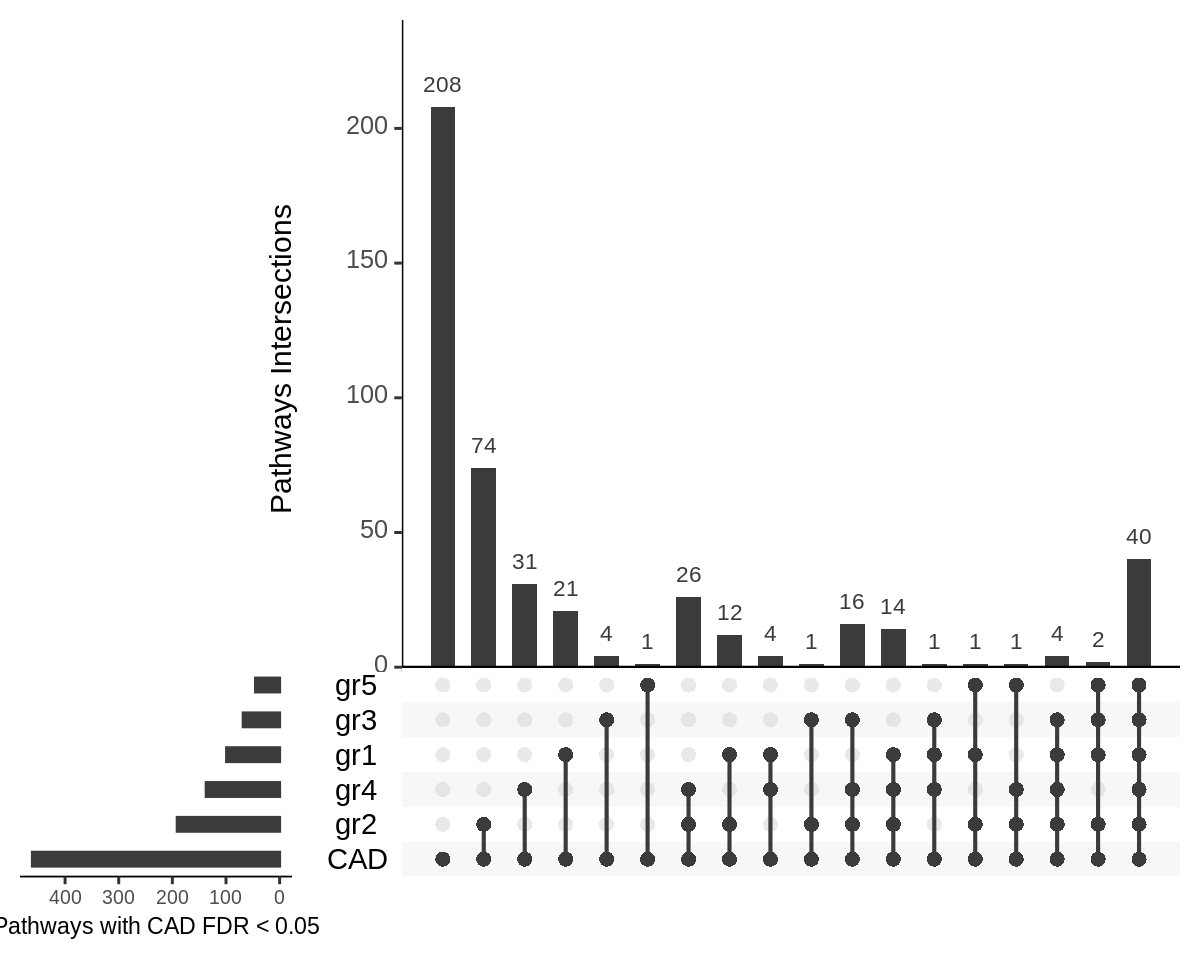

In [137]:
options(repr.plot.width = 6, repr.plot.height = 4.8, repr.plot.res = 200)

# how many in at least one group?
table(rowSums(tmp_mat[,-1] != 0) > 0)
dim(tmp_mat)

# 253 are in at least one group
library(UpSetR)
df <- data.frame(path = rownames(tmp_mat), t(apply(tmp_mat, 1, function(x) as.numeric(x != 0))))
colnames(df)[-1] <- colnames(tmp_mat)

pdf(sprintf('%sUpsetPlot_PALAS_CAD_and_ClusterCases.pdf', outFold), width= 6, height = 4.8)
pl <- upset(df, sets = colnames(tmp_mat), mb.ratio = c(0.7, 0.3),  
      mainbar.y.label = "Pathways Intersections", sets.x.label = "Pathways with CAD FDR < 0.05", 
      text.scale = c(1.3, 1.3, 1, 1, 1.5, 1.3))
dev.off()

upset(df, sets = colnames(tmp_mat), mb.ratio = c(0.7, 0.3),  
      mainbar.y.label = "Pathways Intersections", sets.x.label = "Pathways with CAD FDR < 0.05", 
      text.scale = c(1.3, 1.3, 1, 1, 1.5, 1.3))